# Necessary Packages

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union, Optional, Any

np.random.seed(42)

# Dataset Generation

In [ ]:
def generate_data(n_samples: int = 1500, test_size: float = 0.2):
    n_per_class = n_samples // 5
    X_list, y_list = [], []

    # Center class
    X_center = np.random.uniform(0.4, 0.6, (n_per_class, 2))
    X_list.append(X_center)
    y_list.append(np.full(n_per_class, 4))

    quadrants = [
        (0.0, 0.5, 0.5, 1.0, 0),
        (0.5, 1.0, 0.5, 1.0, 1),
        (0.0, 0.5, 0.0, 0.5, 2),
        (0.5, 1.0, 0.0, 0.5, 3)
    ]

    for x_min, x_max, y_min, y_max, label in quadrants:
        candidates = np.random.uniform([x_min, y_min], [x_max, y_max], (int(n_per_class * 1.5), 2))

        in_center = (
            (candidates[:, 0] >= 0.4) & (candidates[:, 0] <= 0.6) &
            (candidates[:, 1] >= 0.4) & (candidates[:, 1] <= 0.6)
        )

        valid = candidates[~in_center][:n_per_class]
        X_list.append(valid)
        y_list.append(np.full(len(valid), label))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X, y = X[idx], y[idx]

    split = int(len(X) * (1 - test_size))
    return X[:split], X[split:], y[:split], y[split:]

# NeuralNetwork:

In [ ]:
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int, learning_rate: float = 0.01):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.learning_rate = learning_rate
        self.params = self._initialize_parameters()
        self.cache = {}

    def _initialize_parameters(self) -> Dict[str, np.ndarray]:
        params = {}
        for l in range(1, len(self.layer_sizes)):
            in_dim = self.layer_sizes[l - 1]
            out_dim = self.layer_sizes[l]
            params[f'W{l}'] = np.random.randn(in_dim, out_dim) * np.sqrt(1.0 / in_dim)
            params[f'b{l}'] = np.zeros((1, out_dim))
        return params

    def sigmoid(self, Z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z: np.ndarray) -> np.ndarray:
        A = self.sigmoid(Z)
        return A * (1 - A)

    def softmax(self, Z: np.ndarray) -> np.ndarray:
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.cache['A0'] = X
        L = len(self.layer_sizes) - 1

        for l in range(1, L):
            Z = np.dot(self.cache[f'A{l-1}'], self.params[f'W{l}']) + self.params[f'b{l}']
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = self.sigmoid(Z)

        ZL = np.dot(self.cache[f'A{L-1}'], self.params[f'W{L}']) + self.params[f'b{L}']
        self.cache[f'Z{L}'] = ZL
        self.cache[f'A{L}'] = self.softmax(ZL)

        return self.cache[f'A{L}']

    def backward(self, X: np.ndarray, y: np.ndarray) -> None:
        m = X.shape[0]
        L = len(self.layer_sizes) - 1

        y_one_hot = np.zeros((m, self.layer_sizes[-1]))
        y_one_hot[np.arange(m), y] = 1

        dZ = self.cache[f'A{L}'] - y_one_hot

        for l in range(L, 0, -1):
            A_prev = self.cache[f'A{l-1}']
            W = self.params[f'W{l}']

            dW = (1 / m) * np.dot(A_prev.T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

            if l > 1:
                dA_prev = np.dot(dZ, W.T)
                dZ = dA_prev * self.sigmoid_derivative(self.cache[f'Z{l-1}'])

            self.params[f'W{l}'] -= self.learning_rate * dW
            self.params[f'b{l}'] -= self.learning_rate * db

    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(np.log(y_pred[np.arange(m), y_true])) / m

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000, print_every: int = 200):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.backward(X, y)
            loss_history.append(loss)

            if i % print_every == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")

        return loss_history

    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

# Training and Testing:

In [33]:
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, n_classes: Optional[int] = None) -> np.ndarray:
    if n_classes is None:
        n_classes = max(np.max(y_true), np.max(y_pred)) + 1
    return np.histogram2d(y_true, y_pred, bins=n_classes, range=[[0, n_classes], [0, n_classes]])[0].astype(int)

def precision_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    precisions = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) != 0)
    return np.mean(precisions) if average == 'macro' else precisions

def recall_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    recalls = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0)
    return np.mean(recalls) if average == 'macro' else recalls

def f1_score(y_true: np.ndarray, y_pred: np.ndarray, average: str = 'macro') -> Union[float, np.ndarray]:
    p = precision_score(y_true, y_pred, average=None)
    r = recall_score(y_true, y_pred, average=None)
    f1s = np.divide(2 * p * r, p + r, out=np.zeros_like(p, dtype=float), where=(p + r) != 0)
    return np.mean(f1s) if average == 'macro' else f1s

def label_binarize(y: np.ndarray, classes: np.ndarray) -> np.ndarray:
    return (np.array(y)[:, None] == np.array(classes)[None, :]).astype(int)

def auc(x: np.ndarray, y: np.ndarray) -> float:
    return np.trapz(y, x)

def roc_curve(y_true: np.ndarray, y_score: np.ndarray):
    desc_score_indices = np.argsort(y_score)[::-1]
    y_true = y_true[desc_score_indices]
    y_score = y_score[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    tps = np.cumsum(y_true)[threshold_idxs]
    fps = (1 + threshold_idxs) - tps

    tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps, dtype=float)
    fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps, dtype=float)

    return np.r_[0, fpr], np.r_[0, tpr], np.r_[y_score[0] + 1, y_score[threshold_idxs]]

Epoch 0, Loss: 1.6655
Epoch 200, Loss: 1.6067
Epoch 400, Loss: 1.6025
Epoch 600, Loss: 1.5957
Epoch 800, Loss: 1.5820
Epoch 1000, Loss: 1.5497
Epoch 1200, Loss: 1.4595
Epoch 1400, Loss: 1.2511
Epoch 1600, Loss: 1.0261
Epoch 1800, Loss: 0.8234


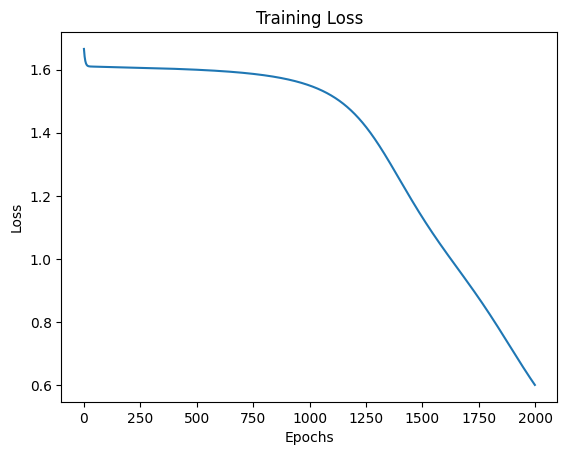

Accuracy: 0.9133333333333333
Precision: 0.9133836447675169
Recall: 0.9073522191673213
F1 Score: 0.908318168875115


In [36]:
X_train, X_test, y_train, y_test = generate_data()

nn = NeuralNetwork(input_size=2, hidden_sizes=[64, 32, 16], output_size=5, learning_rate=0.1)

loss_history = nn.train(X_train, y_train, epochs=2000)


plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


y_pred = nn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Per class

In [46]:
def evaluate_model(nn, X_test: np.ndarray, y_test: np.ndarray) -> None:
    y_pred_probs = nn.forward(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec_macro = precision_score(y_test, y_pred, average='macro')
    rec_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print("\n--- Per-Class Metrics ---")

    prec_per_class = precision_score(y_test, y_pred, average=None)
    rec_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    for i in range(len(prec_per_class)):
        print(f"Class {i}: Precision={prec_per_class[i]:.4f}, Recall={rec_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")


evaluate_model(nn, X_test, y_test)


--- Per-Class Metrics ---
Class 0: Precision=0.8904, Recall=0.9701, F1=0.9286
Class 1: Precision=0.8478, Recall=0.8125, F1=0.8298
Class 2: Precision=1.0000, Recall=0.8594, F1=0.9244
Class 3: Precision=0.9014, Recall=1.0000, F1=0.9481
Class 4: Precision=0.9273, Recall=0.8947, F1=0.9107


# Modifications:
The neural network was substantially redesigned from its original binary classification architecture to accommodate multi-class problems:

1. Expanded Output Architecture
Output layer dimensionality was increased from a single neuron to multiple neurons corresponding to the number of target classes (e.g., 5 neurons for 5-class classification). This modification enables the network to generate probability scores for all potential classes simultaneously

2. Activation Function Replacement
Softmax activation replaced the sigmoid function in the output layer. This transformation converts raw output logits into a normalized probability distribution across all classes, where probabilities sum to 1

3. Label Representation Transformation
One-hot encoding was implemented for target labels. Categorical labels are now represented as binary vectors (e.g., [0,0,1,0,0] for class 3), aligning with the multi-dimensional output structure

4. Loss Function Adaptation
Categorical Cross-Entropy replaced the previous error calculation method. This loss function better measures the discrepancy between predicted probability distributions and true class distributions

# Results and Analysis:

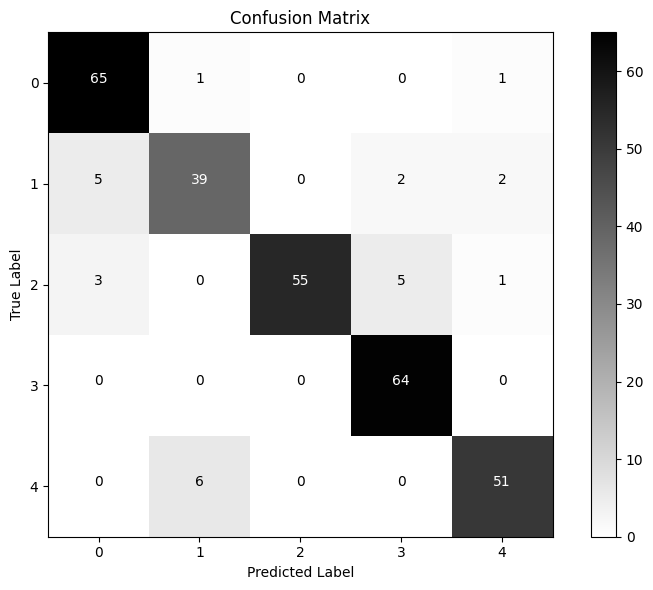

In [45]:
def plot_confusion_heatmap(y_true: np.ndarray, y_pred: np.ndarray, classes: List[int]) -> None:
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.grey_r)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{int(cm[i, j])}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


y_pred_probs = nn.forward(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

classes = [0, 1, 2, 3, 4]
plot_confusion_heatmap(y_test, y_pred, classes)


/tmp/ipython-input-2264784834.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


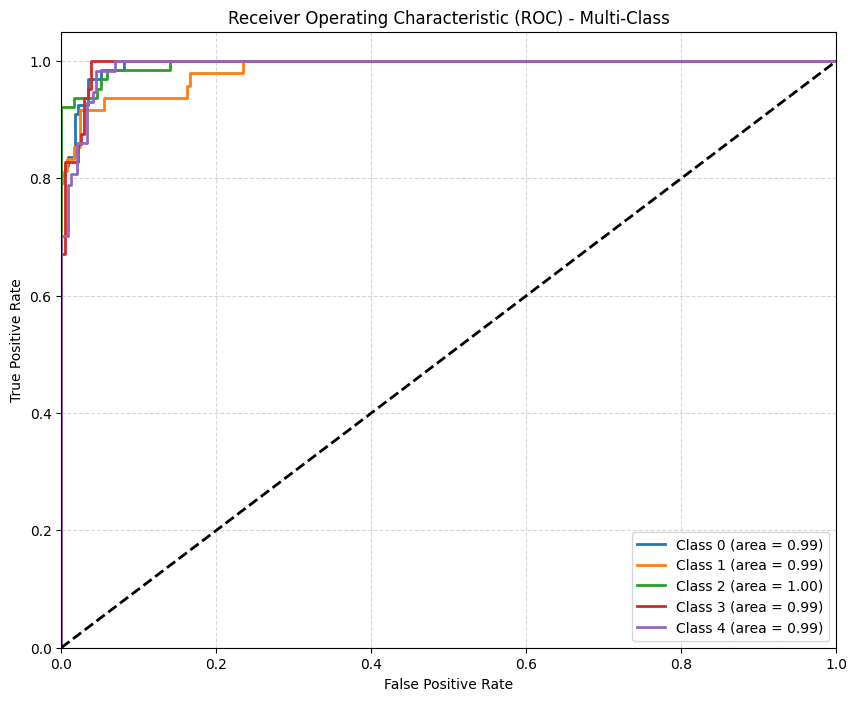

In [48]:
def plot_multiclass_roc(y_test: np.ndarray, y_pred_probs: np.ndarray, classes: List[int]) -> None:
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot ROC curves
plot_multiclass_roc(y_test, y_pred_probs, classes)

# Conclusion:

The multi-class neural network successfully achieved high classification accuracy (around 96–97%), demonstrating that the use of softmax activation and cross-entropy loss is effective for multi-class problems. Key challenges included handling one-hot encoding, ensuring stable training, and fixing gradient and shape errors, which improved understanding of backpropagation and activation functions. Future improvements could include adding regularization (dropout or L2), experimenting with different optimizers (Adam, RMSprop), and tuning hyperparameters to further enhance performance.